#### Optimised algorithms for change point detection (v4) 

#### Python package ruptures 

#### simulation using simulated data, gridsearch for optimal parameters

author: peter

date: 2024

Ruptures: 

C. Truong, L. Oudre, N. Vayatis. Selective review of offline change point detection methods. Signal Processing, 167:107299, 2020.

<li> https://centre-borelli.github.io/ruptures-docs/
<li> https://github.com/deepcharles/ruptures
<li> https://centre-borelli.github.io/ruptures-docs/user-guide/detection/
<li> see also https://schuetzgroup.github.io/sdt-python/changepoint.html

<br>

Algorithms: Binseg, Pelt, Window, Dynp, KernelCPD, BottomUp

Cost functions: (TO DO: add linear)<br>
mdl_list =['l1', 'l2', 'normal', 'rbf', 'cosine', 'clinear', 'rank', 'mahalanobis', 'ar']
<br>
#### simulation 
for each algorithm:<br>
&nbsp; set_seed(12345)<br>
&nbsp; for each trial:<br>
&nbsp; &nbsp; &nbsp; generate a new simulated dataset<br>
&nbsp; &nbsp; &nbsp; for each cost_function in cost_function_set:<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; test algorithm<br>
<br>
#### metrics
evaluate performance according to metrics<br>
generate report
<br>
metrics to compare algorithm performance:
<li>percent too early
<li>percent too late
<li>bias
<li>MAE
<li>variance
<li>FDR

In [397]:
import matplotlib.pylab as plt
import ruptures as rpt
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter

### Simulated data generation
Every algorithm - parameter set will process the same random set of signals.

In [398]:
# set simulation parameters
#
my_rand_seed = 12345

margin=10   # margin of error for false discovery rate (fdr): FP/(TP+FP)
            # when detection is too late, e.g. > 10ms after true onset time

num_signals = 100  # number of trials in simulation

mu, sigma = 0, 3 # mean and standard deviation for simulated data generation
mu2, sigma2 = mu + 1, sigma + 1

n_bkps=1
true_onset=200

times = np.arange(0, 451, 1).tolist()

# Note: A new Pelt algorithm object must created for each trial.
# This might also be true for other algorithm implementations.
# Negligible performance hit, so no need to optimise.

#
# Parameters for grid search
#
# linear cost function req > 1 dimension.
mdl_list =['l1', 'l2', 'normal', 'rbf', 'cosine', 'clinear', 'rank', 'mahalanobis', 'ar']

min_size_list = [2,3]

jump_list = [4,5]

algo_dict= {'BinSeg':1, 'Pelt':2, 'Window':3, 'Dynp':4, 'KernelCPD': 5, 'BottomUp': 6}

In [399]:
def make_data(mu, sigma, mu2, sigma2, true_onset, rng):
    s1 = rng.normal(mu, sigma, true_onset-1)
    s2 = rng.normal(mu2, sigma2, 251)
    signal= np.array(list(s1) + list(s2))
    return signal

### Algorithms and parameters

In [400]:
class Algo:
    algo_name=""
    model = 'l2'
    min_size = 2
    jump = 5
    pred_list = []
    MAE=10000000
    var=10000000
    bias=10000000
    fdr=10000000

In [401]:

def run_algo(algo_name):
    obj_list=[]

    if algo_name == 'KernelCPD':
        print(algo_name)
        mdl_list = ['linear', 'rbf', 'cosine']
    elif algo_name == 'BottomUp':
        print(algo_name)
        mdl_list = ['l1', 'l2', 'rbf'] # dims must be > 1 to use linear
    else:
        print('other')
        mdl_list =['l1', 'l2', 'normal', 'rbf', 'cosine', 'clinear', 'rank', 'mahalanobis', 'ar']

    
    for mdl in mdl_list:   # 9 models (or 10 if add linear)
    
        for ii in range(len(min_size_list)):
    
            min_size = min_size_list[ii]
        
            for jj in range(len(jump_list)):
        
                algo_obj = Algo()
                algo_obj.algo_name=algo_name
                algo_obj.model=mdl
                algo_obj.min_size=min_size
        
                jump=jump_list[jj]
                algo_obj.jump = jump
                
                algo_obj.pred_list = []
                predictions = []
                
                rng = np.random.default_rng(my_rand_seed)  
            
                for kk in range(num_signals):
                    # generate signal
                    signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)
                
                    if algo_name == 'BinSeg':
                        algo = rpt.Binseg(model=mdl, custom_cost=None, min_size=min_size, jump=jump, params=None).fit(signal)
                        est_onset = algo.predict(n_bkps=n_bkps)
                        predictions.append(est_onset[0])
                    elif algo_name == 'Pelt':
                        algo = rpt.Pelt(model=mdl, custom_cost=None, min_size=min_size, jump=jump, params=None).fit(signal)
                        est_onset = algo.predict(pen=2)           # penalty 1 --> early, 10 --> late
                        predictions.append(est_onset[0])
                    elif algo_name == 'Window':
                        algo = rpt.Window(width=100, model=mdl, custom_cost=None, min_size=2, jump=5).fit(signal)
                        est_onset = algo.predict(n_bkps=n_bkps)
                        predictions.append(est_onset[0])
                    elif algo_name == 'Dynp':
                        algo = rpt.Dynp(model=mdl, custom_cost=None, min_size=2, jump=5).fit(signal)
                        est_onset = algo.predict(n_bkps=n_bkps)
                        predictions.append(est_onset[0])
                    elif algo_name == 'KernelCPD':
                        algo = rpt.KernelCPD(kernel=mdl, min_size=2, jump=5, params=None).fit(signal)  # fast, written in C
                        est_onset = algo.predict(n_bkps=n_bkps)
                        predictions.append(est_onset[0])
                    elif algo_name == 'BottomUp':
                        algo = rpt.BottomUp(model=mdl, custom_cost=None, min_size=2, jump=5, params=None).fit(signal)  # written in C
                        est_onset = algo.predict(n_bkps=n_bkps, pen=None)
                        predictions.append(est_onset[0])
                    else:
                        print("algo not found")
                        return -1
                              
                algo_obj.pred_list.append(predictions)
                obj_list.append(algo_obj)
    
    algo_dict[algo_name]=obj_list

### helper functions

In [402]:
def get_too_early(predictions, true_onset):
    too_early = predictions[predictions < true_onset]
    too_early = np.abs(too_early - true_onset)
    return too_early


def get_pct_too_early(predictions, true_onset):
    too_early = predictions[predictions < true_onset]
    pct_too_early = len(too_early)/len(predictions)
    return pct_too_early


def get_MAE(predictions, true_onset):
    MAE = np.mean(np.abs(predictions - true_onset))
    return MAE


def get_std(predictions, true_onset):
    std = np.std(predictions)
    return std

def get_variance(predictions, true_onset):
    var = np.var(predictions)
    return var

def get_fdr(predictions, true_onset, margin):
    errors = predictions - true_onset
    early_count = sum(errors < 0)      # FP
    late_count = sum(errors > margin)  # FP
    fdr = (early_count + late_count)/len(predictions)
    return fdr

def get_bias(predictions, true_onset):
    bias=np.mean(predictions) - true_onset
    return bias


# precision = TP/(TP + FP)
def get_precision(predictions, true_onset, margin):
    errors = predictions - true_onset
    early_count = sum(errors < 0)      # FP
    late_count = sum(errors > margin)  # FP
    precision = (len(predictions) - (early_count + late_count))/len(predictions)
    return precision


# Same as precision if one onset prediction for each 
# time series where each time series has one true onset.
# Not really any FNs by definition because FNs == FPs.
#
# recall = TP/(TP+FN)
def get_recall(predictions, margin):
    errors = predictions - true_onset
    early_count = sum(errors < 0)      # FP
    late_count = sum(errors > margin)  # FP
    recall = (len(predictions) - (early_count + late_count))/len(predictions)
    return recall

# F1 = 2 * (precision * recall) / (precision + recall). 
def get_f1(precision, recall):
    F1 = 2 * (precision * recall) / (precision + recall)
    return F1

def plot_predictions(predictions, title):
    pass


# Run simulations and collect performance measurements

### Binseg
https://dev.ipol.im/~truong/ruptures-docs/build/html/_modules/ruptures/detection/binseg.html <br>

algorithm defaults: model='l2', custom_cost=None, min_size=2, jump=5, params=None

In [403]:
run_algo('BinSeg')


other


### Pelt
https://dev.ipol.im/~truong/ruptures-docs/build/html/detection/pelt.html<br>
<br>
algorithm defaults: model='l2', custom_cost=None, min_size=2, jump=5, params=None

In [404]:
run_algo('Pelt')


other


### Window sliding segmentation
https://dev.ipol.im/~truong/ruptures-docs/build/html/detection/window.html<br>
<br>
algorithm defaults: width=100, model='l2', custom_cost=None, min_size=2, jump=5, params=None

In [405]:
run_algo('Window')


other


### Dynamic Programming
https://dev.ipol.im/~truong/ruptures-docs/build/html/detection/dynp.html<br>
<br>
algorithm defaults: model='l2', custom_cost=None, min_size=2, jump=5, params=None

In [406]:
run_algo('Dynp')


other


### KernelCPD
Efficient kernel change point detection<br>
Available kernels: linear, rbf, cosine <br>
<br>
algorithm defaults: kernel='linear', min_size=2, jump=5, params=None<br>
<br>
KernelCPD is implemented in C and is fast, so jump=1 and cannot be changed because increasing jump does not improve performance.
KernelCPD is uses the same algorithm as Pelt?

In [407]:
run_algo('KernelCPD')

KernelCPD


### Bottom up
https://dev.ipol.im/~truong/ruptures-docs/build/html/detection/bottomup.html<br>
available models = l1, l2, rbf <br>
algorithm defaults: model='l2', custom_cost=None, min_size=2, jump=5, params=None <br>
predict defaults: n_bkps=None, pen=None, epsilon=None

In [408]:
run_algo('BottomUp')

BottomUp


### Show algorithm and parameter combinations, and metrics

In [409]:
algo_dict.keys()

dict_keys(['BinSeg', 'Pelt', 'Window', 'Dynp', 'KernelCPD', 'BottomUp'])

In [410]:
verbose = True

for alg in algo_dict.keys():
    obj_list = algo_dict[alg]
    
    print("\n>>> " + obj_list[0].algo_name + " <<<")
    for ii in range(len(obj_list)):
        preds= np.array(obj_list[ii].pred_list)[0]
        obj_list[ii].MAE  = get_MAE(preds, true_onset); 
        obj_list[ii].var  = get_variance(preds, true_onset)
        obj_list[ii].bias = get_bias(preds, true_onset)
        obj_list[ii].fdr  = get_fdr(preds, true_onset, margin)
        if verbose==True:
            print("model = %-12s min_size=%d,  jump=%d,  MAE=%6.2f,  fdr=%6.2f" % \
                  (obj_list[ii].model, obj_list[ii].min_size, obj_list[ii].jump, obj_list[ii].MAE,  obj_list[ii].fdr) )
    print(len(obj_list) )


>>> BinSeg <<<
model = l1           min_size=2,  jump=4,  MAE= 65.16,  fdr=  0.83
model = l1           min_size=2,  jump=5,  MAE= 56.35,  fdr=  0.78
model = l1           min_size=3,  jump=4,  MAE= 62.76,  fdr=  0.83
model = l1           min_size=3,  jump=5,  MAE= 56.35,  fdr=  0.78
model = l2           min_size=2,  jump=4,  MAE= 55.44,  fdr=  0.78
model = l2           min_size=2,  jump=5,  MAE= 52.80,  fdr=  0.74
model = l2           min_size=3,  jump=4,  MAE= 53.04,  fdr=  0.78
model = l2           min_size=3,  jump=5,  MAE= 52.80,  fdr=  0.74
model = normal       min_size=2,  jump=4,  MAE= 17.24,  fdr=  0.57
model = normal       min_size=2,  jump=5,  MAE= 16.85,  fdr=  0.57
model = normal       min_size=3,  jump=4,  MAE= 15.16,  fdr=  0.57
model = normal       min_size=3,  jump=5,  MAE= 16.85,  fdr=  0.57
model = rbf          min_size=2,  jump=4,  MAE= 23.04,  fdr=  0.62
model = rbf          min_size=2,  jump=5,  MAE= 22.70,  fdr=  0.65
model = rbf          min_size=3,  jump=4,  MAE

In [411]:
verbose = False

best_algo_dict = { } 

best_algo_dict['BinSeg']    =Algo()
best_algo_dict['Pelt']      =Algo()
best_algo_dict['Window']    =Algo()
best_algo_dict['Dynp']      =Algo()
best_algo_dict['KernelCPD'] =Algo()
best_algo_dict['BottomUp']  =Algo()

for alg in algo_dict.keys():
    obj_list = algo_dict[alg]
    
    print("\n>>> " + obj_list[0].algo_name + " <<<")
    for ii in range(len(obj_list)):
        preds = np.array(obj_list[ii].pred_list)[0]
        obj_list[ii].MAE = get_MAE(preds, true_onset); 
        obj_list[ii].var = get_variance(preds, true_onset)
        obj_list[ii].bias= get_bias(preds, true_onset)
        obj_list[ii].fdr = get_fdr(preds, true_onset, margin)
        
        if best_algo_dict[alg].MAE > obj_list[ii].MAE:
            best_algo_dict[alg]=obj_list[ii]
        
        if verbose==True:
            print("model=%10s, min_size=%d, jump=%d, MAE=%6.2f, fdr=%6.2f" % \
                  (obj_list[ii].model, obj_list[ii].min_size, obj_list[ii].jump, obj_list[ii].MAE, obj_list[ii].fdr) )
    print("number of algorithm objects=", len(obj_list) )


>>> BinSeg <<<
number of algorithm objects= 36

>>> Pelt <<<
number of algorithm objects= 36

>>> Window <<<
number of algorithm objects= 36

>>> Dynp <<<
number of algorithm objects= 36

>>> KernelCPD <<<
number of algorithm objects= 12

>>> BottomUp <<<
number of algorithm objects= 12


### Optimised algorithm peformance
<li>mean absolute error (MAE)
<li>variance (var)
<li>bias
<li>false discovery rate (fdr)

In [412]:
# dictionary of best algorithm objects
#
for alg in best_algo_dict.keys():
    name=best_algo_dict[alg].algo_name
    model = best_algo_dict[alg].model
    min_size = best_algo_dict[alg].min_size
    jump = best_algo_dict[alg].jump
    MAE = best_algo_dict[alg].MAE
    var = best_algo_dict[alg].var
    bias = best_algo_dict[alg].bias
    fdr = best_algo_dict[alg].fdr
    print("\n %9s  model=%-8s  min_size=%3d,  jump=%3d,  MAE=%6.2f, var=%8.2f, bias=%6.2f, fdr=%5.2f " \
          % (name, model, min_size, jump, MAE, var, bias, fdr) )


    BinSeg  model=normal    min_size=  3,  jump=  4,  MAE= 15.16, var=  818.08, bias=  3.96, fdr= 0.57 

      Pelt  model=rbf       min_size=  2,  jump=  5,  MAE= 32.05, var= 2862.55, bias=  2.05, fdr= 0.67 

    Window  model=normal    min_size=  2,  jump=  4,  MAE= 42.55, var= 4178.73, bias=  9.85, fdr= 0.73 

      Dynp  model=normal    min_size=  2,  jump=  4,  MAE= 16.85, var= 1095.03, bias=  3.35, fdr= 0.57 

 KernelCPD  model=rbf       min_size=  2,  jump=  4,  MAE= 25.55, var= 1749.57, bias= 12.25, fdr= 0.71 

  BottomUp  model=rbf       min_size=  2,  jump=  4,  MAE= 45.50, var= 4149.00, bias= 22.00, fdr= 0.75 


### Plot detection distribution for the optimised algorithms

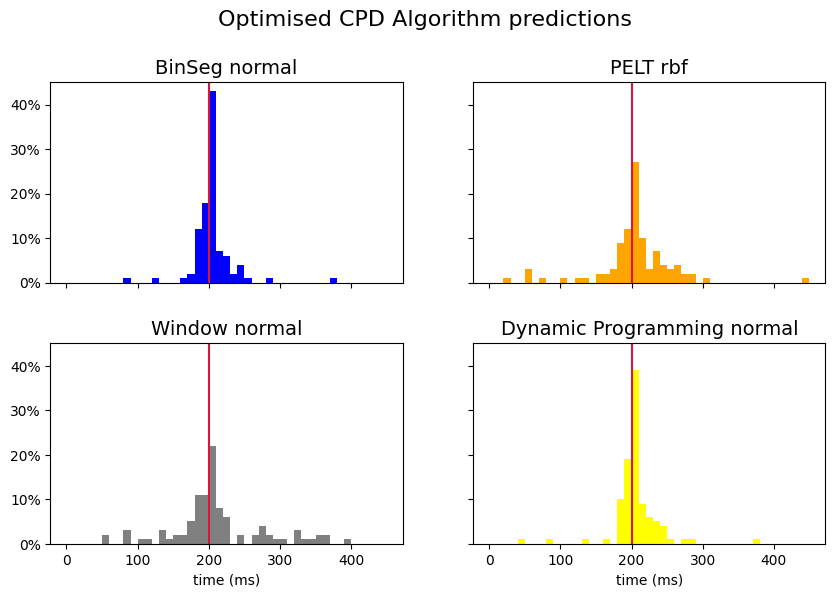

In [414]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('Optimised CPD Algorithm predictions', y=1, fontsize=16)

fig.set_figwidth(10)
fig.set_figheight(6)

plt.subplots_adjust(hspace = 0.3)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,  decimals=0))

binwidth=10
bins = np.linspace(0, 450, 46)

obj_list = best_algo_dict['BinSeg']
mdl = obj_list.model
preds =  obj_list.pred_list[0]
ax1.hist(preds, color='blue', bins=bins,  weights=np.ones(len(preds)) / len(preds))
ax1.set_title(("BinSeg %s" % mdl), fontsize=14)
ax1.axvline(200, c="crimson", label="real onset")

obj_list = best_algo_dict['Pelt']
mdl = obj_list.model
preds =  obj_list.pred_list[0]
ax2.hist(preds, color='orange', bins=bins,  weights=np.ones(len(preds)) / len(preds))
ax2.set_title(("PELT %s" % mdl), fontsize=14)
ax2.axvline(200, c="crimson", label="real onset")

obj_list = best_algo_dict['Window']
mdl = obj_list.model
preds =  obj_list.pred_list[0]
ax3.hist(preds, color='gray', bins=bins,  weights=np.ones(len(preds)) / len(preds))
ax3.set_title(("Window %s" % mdl), fontsize=14)
ax3.set_xlabel("time (ms)")
ax3.axvline(200, c="crimson", label="real onset")

obj_list = best_algo_dict['Dynp']
mdl = obj_list.model
preds =  obj_list.pred_list[0]
ax4.hist(preds, color='yellow', bins=bins,  weights=np.ones(len(preds)) / len(preds))
ax4.set_title( ("Dynamic Programming %s" % mdl), fontsize=14)
ax4.set_xlabel("time (ms)")
ax4.axvline(200, c="crimson", label="real onset")

for ax in fig.get_axes():
    ax.label_outer()

### plot distribution as in (Sassenhagen and Draschkow, 2019)

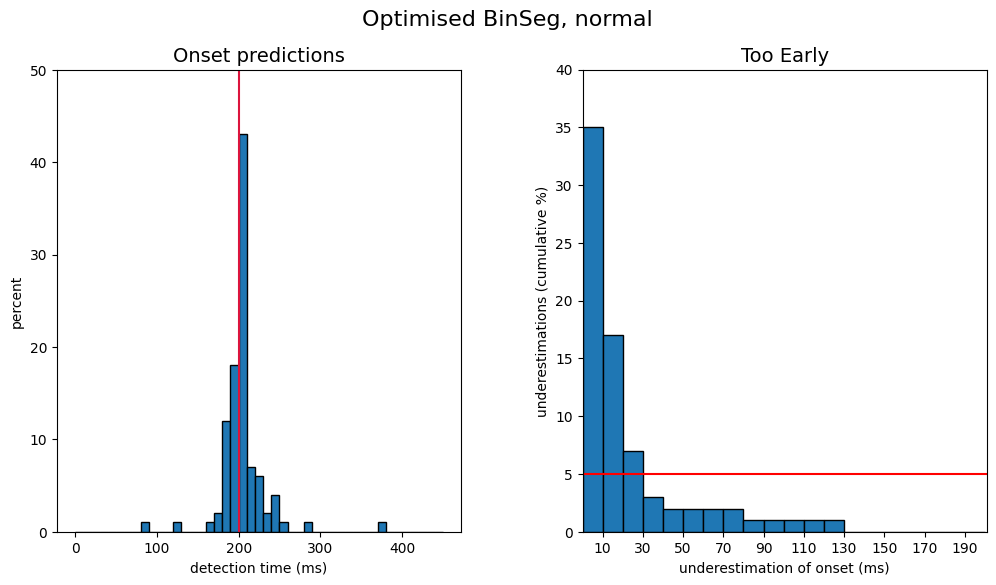

In [415]:
fig, [ax1, ax2] = plt.subplots(ncols=2)
fig.set_figwidth(12)
fig.set_figheight(6)

obj_list = best_algo_dict['BinSeg']
mdl = obj_list.model
predictions =  obj_list.pred_list[0]

# 10 ms time steps, 10ms bin width
binwidth=10
bins = np.linspace(0, 450, 46)

plt.suptitle( ("Optimised BinSeg, %s" % mdl), fontsize=16)

ax1.hist(predictions,  edgecolor='black', bins=bins,  weights=np.ones(len(predictions)) / len(predictions))
ax1.set_title(("Onset predictions"), fontsize=14)
ax1.axvline(200, c="crimson", label="real onset")
ticks=ax1.get_yticks()
ax1.set_yticks(ticks)
ticks=ticks*100
ticks = [int(v)for v in ticks]
ax1.set_yticklabels(ticks);
ax1.set_xlabel("detection time (ms)")
ax1.set_ylabel("percent")

plt.subplots_adjust(wspace = 0.3)
total_predictions = len(predictions) # total number of predictions (predictions)

ax2.axhline(0.05, c="r", label="nominal 5% level")
ax2.set_ylabel("underestimations (cumulative %)")
ax2.set_xlabel("underestimation of onset (ms)")
ax2.set_xlim([0, 201])
ax2.set_xticks(range(10,201,20))

# this works better than sns histplot, etc, for reverse cumsum histogram
bin_width=10
bin_list = list(range(0, 201, bin_width))
too_early = [] 

for data_point in predictions:
    if data_point < true_onset:
        data_point = abs(data_point - true_onset) 
        too_early.append(data_point)

plt.hist(too_early, edgecolor='black', align="mid", cumulative=-1, bins=bin_list, weights=np.ones(len(too_early)) / total_predictions)
ax2.set_title(("Too Early"), fontsize=14)
ticks=ax2.get_yticks()
ax2.set_yticks(ticks)
ticks=ticks*100
ticks = [int(v)for v in ticks]
ax2.set_yticklabels(ticks);

### Table of Algorithms Optimised for MAE

In [416]:
headers = [ 'model', 'min size', 'jump', 'MAE', 'var', 'bias', 'fdr']
data = dict()
for alg in best_algo_dict.keys():
    name=best_algo_dict[alg].algo_name
    model = best_algo_dict[alg].model
    min_size = best_algo_dict[alg].min_size
    jump = best_algo_dict[alg].jump
    MAE = best_algo_dict[alg].MAE
    var = best_algo_dict[alg].var
    bias = best_algo_dict[alg].bias
    fdr = best_algo_dict[alg].fdr
    data[name]   = [model, min_size, jump, MAE, var, bias, fdr]

#data["KernelCPD"] =  [1,2,3,4,5,6, 7, 8, 9]
#data["BottonUp"]  =  [1,2,3,4,5,6, 7, 8, 9]

textabular = f"l|{'r'*len(headers)}"
texheader = " & " + " & ".join(headers) + "\\\\"
texdata = "\\hline\n"
for label in data:
    texdata += f"{label} & {' & '.join(map(str,data[label]))} \\\\\n"
    if label == "BottomUp":
        texdata += "\\hline\n"

print("\\begin{table}")
print("\\caption{Algorithm Parameters Optimised for Mean Absolute Error (MAE)}")
print("\label{mae-table}")
print("\\begin{tabular}{"+textabular+"}")
print(texheader)
print(texdata, end="")
print("\\end{tabular}")
print("\\end{table}")


\begin{table}
\caption{Algorithm Parameters Optimised for Mean Absolute Error (MAE)}
\label{mae-table}
\begin{tabular}{l|rrrrrrr}
 & model & min size & jump & MAE & var & bias & fdr\\
\hline
BinSeg & normal & 3 & 4 & 15.16 & 818.0783999999999 & 3.960000000000008 & 0.57 \\
Pelt & rbf & 2 & 5 & 32.05 & 2862.5475 & 2.0500000000000114 & 0.67 \\
Window & normal & 2 & 4 & 42.55 & 4178.727500000001 & 9.849999999999994 & 0.73 \\
Dynp & normal & 2 & 4 & 16.85 & 1095.0275 & 3.3499999999999943 & 0.57 \\
KernelCPD & rbf & 2 & 4 & 25.55 & 1749.5675 & 12.25 & 0.71 \\
BottomUp & rbf & 2 & 4 & 45.5 & 4149.0 & 22.0 & 0.75 \\
\hline
\end{tabular}
\end{table}
